In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
#from xgboost import plot_tree, plot_importance
from sklearn.metrics import accuracy_score, auc, recall_score, precision_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
import graphviz

from sklearn.cross_validation import train_test_split
# more
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV 

In [52]:
df = pd.read_csv("data/data_with_added_dummies.csv")
#y = df["y"]
#cols_to_remove_from_features = ["y", "campaign"]
#X = df[[col for col in df.columns.tolist() if col not in cols_to_remove_from_features]]
#df["y"].mean()

train, test = train_test_split(df, test_size=0.25, stratify=df["y"], random_state=42)
#train_and_test, final_test = train_test_split(df, test_size=0.10, stratify=df["y"], random_state=42)
#train, test = train_test_split(train_and_test, test_size=0.10, stratify=train_and_test["y"], random_state=42)

In [169]:
def modelfit(alg, dtrain, predictors, target, dtest, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, stratified=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    ytest_predictions = alg.predict(dtest[predictors])
    ytest_predprob = alg.predict_proba(dtest[predictors])[:,1]
#     threshold=0.6
#     ytest_predictions = (ytest_predprob > threshold).astype(int)
#    print ytest_predictions
        
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : {0}".format(metrics.accuracy_score(dtest[target].values, ytest_predictions))
    print "Recall: {0}".format(recall_score(dtest[target].values, ytest_predictions))
    print "AUC Score (Test): {0}".format(metrics.roc_auc_score(dtest[target], ytest_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom='off',      # ticks along the bottom edge are off
#         top='off',         # ticks along the top edge are off
#         labelbottom='off')
    plt.show()
    fpr, tpr, thresholds = roc_curve(dtest[target], ytest_predprob)
    print thresholds
    #plt.plot(fpr,tpr)
    plt.scatter(fpr,tpr, c=(thresholds<0.8), s=10)
    plt.show() 


Model Report
Accuracy : 0.9177
AUC Score (Train): 0.949619


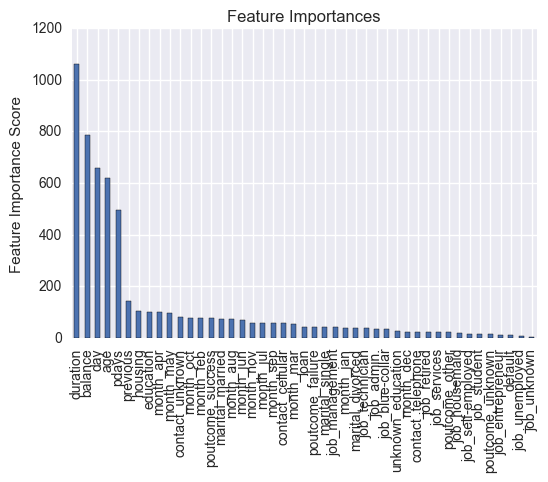

In [32]:
predictors = [x for x in train.columns if x not in cols_to_remove_from_features]
target = "y"
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors, target, test)

In [4]:
predictors = ['age', 'education', 'default', 'balance', 'housing', 
              'loan', 'duration', 'pdays', 'previous',
               'unknown_education', 'job_admin.', 'job_blue-collar',
              'job_entrepreneur', 'job_housemaid', 'job_management',
              'job_retired', 'job_self-employed', 'job_services', 'job_student',
              'job_technician', 'job_unemployed', 'job_unknown',
              'marital_divorced', 'marital_married', 'marital_single',
              'contact_cellular', 'contact_telephone', 'contact_unknown',
              'poutcome_failure', 'poutcome_other',
              'poutcome_success', 'poutcome_unknown']
target = "y"
# xgb2 = XGBClassifier(
#  learning_rate =0.1,
#  n_estimators=1000,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'binary:logistic',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27)
# modelfit(xgb2, train, predictors, target, test)

In [ ]:
param_test1 = {
 'max_depth':range(3, 6),#10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=8,iid=False, cv=2)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


Model Report
Accuracy : 0.9029
AUC Score (Train): 0.897430


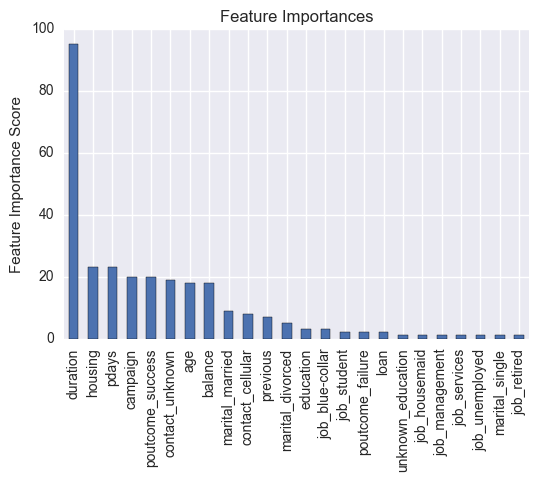

In [8]:
modelfit(gsearch1.best_estimator_, train, predictors, target, test)


Model Report
Accuracy : 0.9044
AUC Score (Train): 0.915828


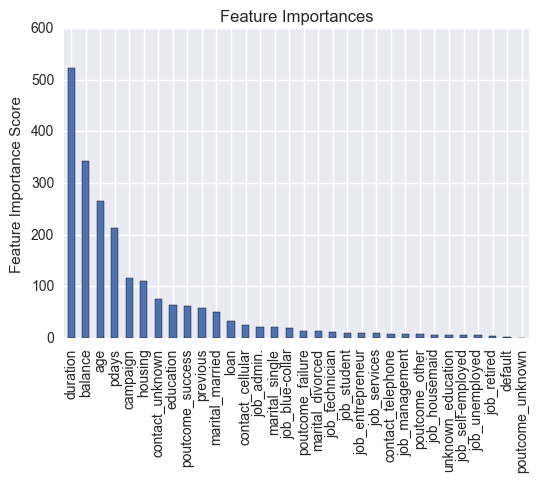

In [5]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=8,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, predictors, target, test)


Model Report
Accuracy : 0.901176678758
Recall: 0.339636913767
AUC Score (Test): 0.901571533569


AttributeError: 'Series' object has no attribute 'get_xticklabels'

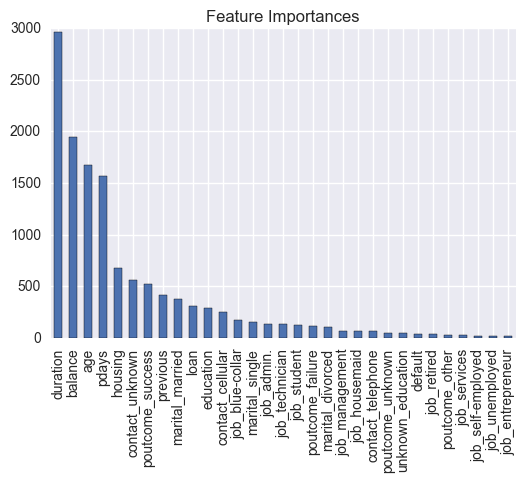

In [168]:
xgb4 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=500,
    max_depth=5,
    min_child_weight=4,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.7,
    reg_alpha=0.01,
    objective= 'binary:logistic',
    nthread=8,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb4, train, predictors, target, test)

### feature selection

In [15]:
top_features = [f for (f, s) in xgb4.booster().get_fscore().iteritems() if s > 200]
print top_features
top_features1 = [f for (f, s) in xgb4.booster().get_fscore().iteritems() if s > 150]
print top_features1

['contact_cellular', 'loan', 'duration', 'education', 'pdays', 'previous', 'housing', 'marital_married', 'poutcome_success', 'age', 'contact_unknown', 'balance']
['contact_cellular', 'loan', 'marital_single', 'duration', 'education', 'pdays', 'previous', 'housing', 'marital_married', 'poutcome_success', 'job_blue-collar', 'age', 'contact_unknown', 'balance']


In [36]:
train1 = train[top_features1 + ["y"]]
test1 = test[top_features1+ ["y"]]
train1.head()

,contact_cellular,loan,marital_single,duration,education,pdays,previous,housing,marital_married,poutcome_success,job_blue-collar,age,contact_unknown,balance,y
21159,1.0,0,0.0,38,12.0,-1,0,0,1.0,0.0,0.0,42,0.0,688,0
20336,1.0,0,0.0,149,12.0,-1,0,0,1.0,0.0,0.0,52,0.0,7742,0
18963,1.0,1,0.0,378,12.0,-1,0,0,1.0,0.0,1.0,56,0.0,302,0
35587,1.0,0,0.0,245,12.0,366,2,1,1.0,0.0,1.0,50,0.0,26,0
18038,1.0,0,0.0,535,6.0,-1,0,1,1.0,0.0,1.0,44,0.0,276,0



Model Report
Accuracy : 0.9064
AUC Score (Train): 0.912912


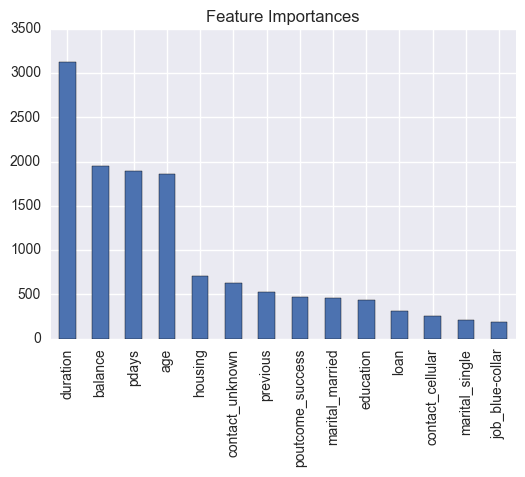

In [20]:
xgb5 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=500,
    max_depth=5,
    min_child_weight=4,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.7,
    reg_alpha=0.01,
    objective= 'binary:logistic',
    nthread=8,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb4, train1, top_features1, target, test1)


Model Report
Accuracy : 0.906365200295
Recall: 0.382352941176
AUC Score (Test): 0.91291189451


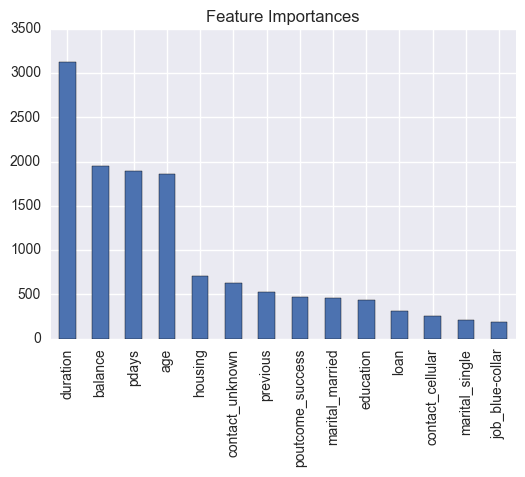

[ 0.86063081  0.8544929   0.85028142  0.82469535  0.82295257  0.78768349
  0.7802825   0.77057409  0.76892424  0.76362509  0.76351786  0.73501021
  0.72974336  0.72558796  0.72392851  0.71447963  0.70731163  0.70571733
  0.70517999  0.70047826  0.69973493  0.6953724   0.69134581  0.68654209
  0.68618661  0.68146408  0.68129331  0.67784882  0.67638117  0.67360306
  0.66931313  0.66482854  0.66156834  0.6598345   0.65953267  0.65753108
  0.65560967  0.65154123  0.65152991  0.65093344  0.64530754  0.64326632
  0.64322597  0.64300716  0.64113903  0.63621622  0.63571769  0.6343677
  0.63324159  0.63314629  0.63083488  0.62850428  0.62792867  0.62128603
  0.61812484  0.60654253  0.60533303  0.60284489  0.59519744  0.59257388
  0.59022409  0.5838272   0.58312505  0.57979125  0.57969934  0.57953006
  0.57870406  0.56808639  0.56700599  0.563434    0.55920261  0.55676496
  0.55664432  0.55595338  0.55572438  0.55517536  0.55516946  0.55343556
  0.55341947  0.55304277  0.55116189  0.54967314  0.

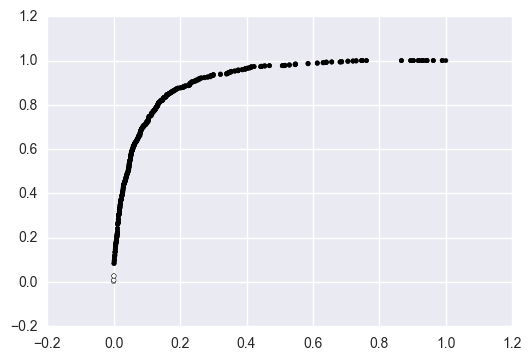

In [109]:
xgb6 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=500,
    max_depth=5,
    min_child_weight=4,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.7,
    reg_alpha=0.01,
    objective= 'binary:logistic',
    nthread=8,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb6, train1, top_features1, target, test1)

In [61]:
top_features2 = [f for (f, s) in xgb6.booster().get_fscore().iteritems() if s > 200]
print top_features2
train2 = train[top_features2 + ["y"]]
test2 = test[top_features2 + ["y"]]

['contact_cellular', 'balance', 'pdays', 'age', 'marital_single', 'contact_unknown', 'marital_married', 'duration', 'loan', 'education', 'poutcome_success', 'housing', 'previous']



Model Report
Accuracy : 0.901265150845
Recall: 0.339636913767
AUC Score (Test): 0.901526478221


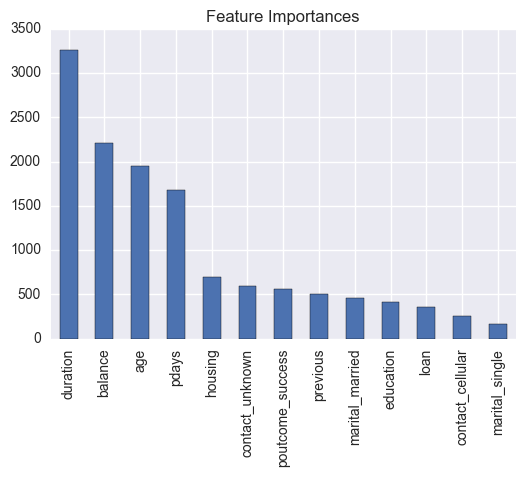

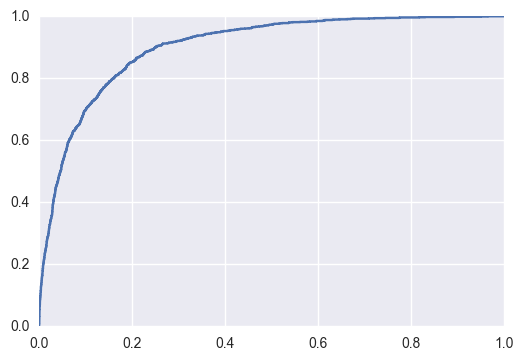

In [72]:
xgb7 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=500,
    max_depth=5,
    min_child_weight=4,
    gamma=0.1,
    subsample=0.9,
    colsample_bytree=0.7,
    reg_alpha=0.01,
    objective= 'binary:logistic',
    nthread=8,
    scale_pos_weight=1,
    seed=27)
modelfit(xgb7, train2, top_features2, target, test2)

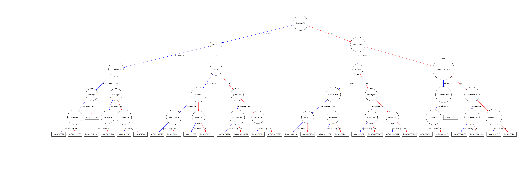

In [166]:
xgb.plot_tree(xgb6, num_trees=2)
plt.savefig("graph_final_1.png", dpi=800)


Model Report
Accuracy : 0.897026296387
Recall: 0.634453781513
Precision: 0.5521023766
AUC Score (Test): 0.91291189451
average predicted true: 0.134431064144
[ 0.86063081  0.8544929   0.85028142  0.82469535  0.82295257  0.78768349
  0.7802825   0.77057409  0.76892424  0.76362509  0.76351786  0.73501021
  0.72974336  0.72558796  0.72392851  0.71447963  0.70731163  0.70571733
  0.70517999  0.70047826  0.69973493  0.6953724   0.69134581  0.68654209
  0.68618661  0.68146408  0.68129331  0.67784882  0.67638117  0.67360306
  0.66931313  0.66482854  0.66156834  0.6598345   0.65953267  0.65753108
  0.65560967  0.65154123  0.65152991  0.65093344  0.64530754  0.64326632
  0.64322597  0.64300716  0.64113903  0.63621622  0.63571769  0.6343677
  0.63324159  0.63314629  0.63083488  0.62850428  0.62792867  0.62128603
  0.61812484  0.60654253  0.60533303  0.60284489  0.59519744  0.59257388
  0.59022409  0.5838272   0.58312505  0.57979125  0.57969934  0.57953006
  0.57870406  0.56808639  0.56700599  0.

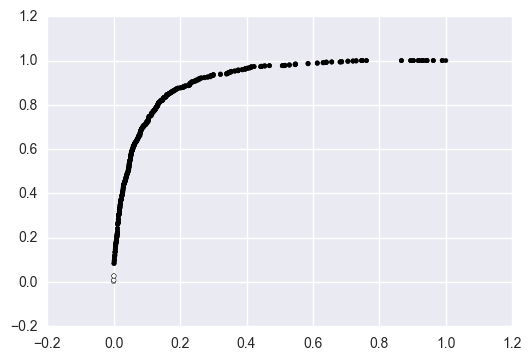

In [141]:
#for the final model:
#ytest_predictions = xgb6.predict(test1[top_features1])
ytest_predprob = xgb6.predict_proba(test1[top_features1])[:,1]
threshold=0.20
ytest_predictions = (ytest_predprob > threshold).astype(int)
#    print ytest_predictions


#Print model report:
print "\nModel Report"
print "Accuracy : {0}".format(metrics.accuracy_score(test1[target].values, ytest_predictions))
print "Recall: {0}".format(recall_score(test1[target].values, ytest_predictions))
print "Precision: {0}".format(precision_score(test1[target].values, ytest_predictions))
print "AUC Score (Test): {0}".format(metrics.roc_auc_score(test1[target], ytest_predprob))
print "average predicted true: {0}".format(ytest_predictions.mean())

fpr, tpr, thresholds = roc_curve(test1[target], ytest_predprob)
#plt.plot(fpr,tpr)
plt.scatter(fpr,tpr, c=(thresholds<0.8), s=10)
plt.show() 

In [147]:
recall = []
precision = []
average_predicted_true = []
for threshold in range(100):
    thr = float(threshold) / 100
    predictions = (ytest_predprob > thr).astype(int)
    recall.append(recall_score(test1[target].values, predictions))
    precision.append(precision_score(test1[target].values, predictions))
    average_predicted_true.append(predictions.mean())

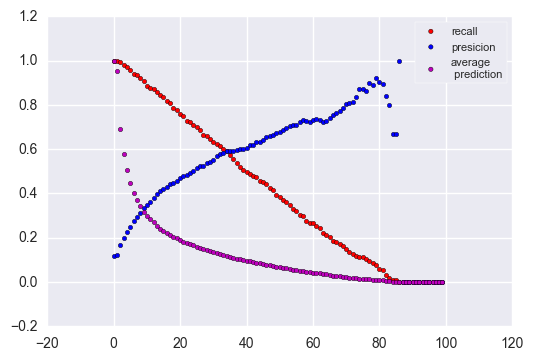

In [164]:
plt.scatter(x=range(100), y=recall,c="r", s=10, label="recall")
plt.scatter(x=range(100), y=precision,c="b", s=10, label="presicion")
plt.scatter(x=range(100), y=average_predicted_true,c="m", s=10, label="average\n prediction")
plt.legend(fontsize=8, frameon=True)
plt.show()


Model Report
Accuracy : 0.88768739248
Recall: 0.699579831933
Precision: 0.514683153014
AUC Score (Test): 0.91291189451
average predicted true: 0.159007127058


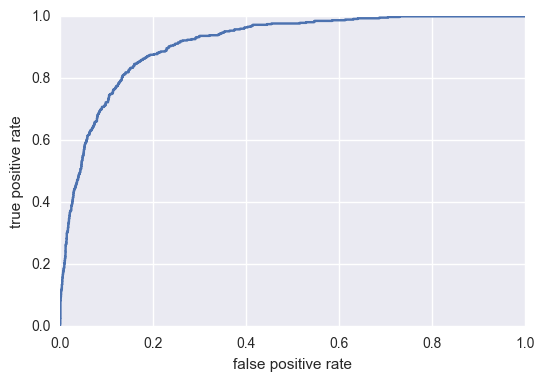

In [165]:
#for the final model:
ytest_predprob = xgb6.predict_proba(test1[top_features1])[:,1]
threshold=0.25
ytest_predictions = (ytest_predprob > threshold).astype(int)


#Print model report:
print "\nModel Report"
print "Accuracy : {0}".format(metrics.accuracy_score(test1[target].values, ytest_predictions))
print "Recall: {0}".format(recall_score(test1[target].values, ytest_predictions))
print "Precision: {0}".format(precision_score(test1[target].values, ytest_predictions))
print "AUC Score (Test): {0}".format(metrics.roc_auc_score(test1[target], ytest_predprob))
print "average predicted true: {0}".format(ytest_predictions.mean())

fpr, tpr, thresholds = roc_curve(test1[target], ytest_predprob)
plt.plot(fpr,tpr)
plt.ylabel("true positive rate")
plt.xlabel("false positive rate")
#plt.scatter(fpr,tpr, c=(thresholds<0.8), s=10)
plt.show() 

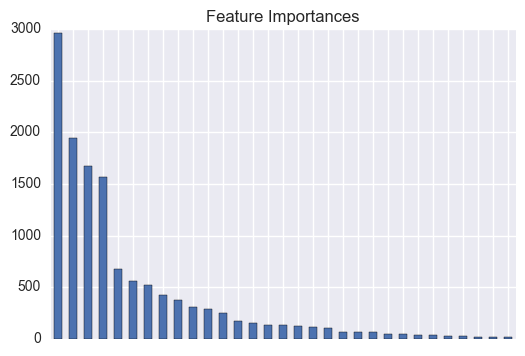

In [170]:
feat_imp = pd.Series(xgb4.booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.show()